# Assignment 3: Improving the Pipeline
## DonorsChoose Dataset
### Kyle Schindl

## Part 1: Data Cleaning:

First, we commence with some minor data cleaning, as well as data visualization and summary statistics to better understand our dataset

In [1]:
import HW5_pipeline as up
import pandas as pd

#Read in dataset
data = pd.read_csv('projects_2012_2013.csv')

#Convert relevant columns to datetime
data['date_posted'] = pd.to_datetime(data.date_posted)
data['datefullyfunded'] = pd.to_datetime(data.datefullyfunded)

#Create target column based on chosen criteria
data['target'] = ((data['datefullyfunded'] - data['date_posted']).dt.days > 60) * 1

#Create categorical variables for data analysis
for col in ['school_metro', 'primary_focus_subject', 'primary_focus_area', 'secondary_focus_area',
            'secondary_focus_subject', 'secondary_focus_area', 'teacher_prefix', 'poverty_level',
            'resource_type', 'school_state', 'grade_level']:
    data[col] = data[col].astype('category')

#Convert string columns to dummy variables
up.convert_tf(data, ['school_magnet', 'school_charter', 'eligible_double_your_impact_match'], 'f')

#Drop superfluous columns
data = data.drop(['projectid', 'teacher_acctid', 'schoolid', 'school_ncesid',
                  'school_latitude', 'school_longitude', 'school_city', 'school_state',
                  'school_district', 'school_county', 'secondary_focus_area',
                  'secondary_focus_subject'], axis=1)

/usr/local/lib/python3.5/dist-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


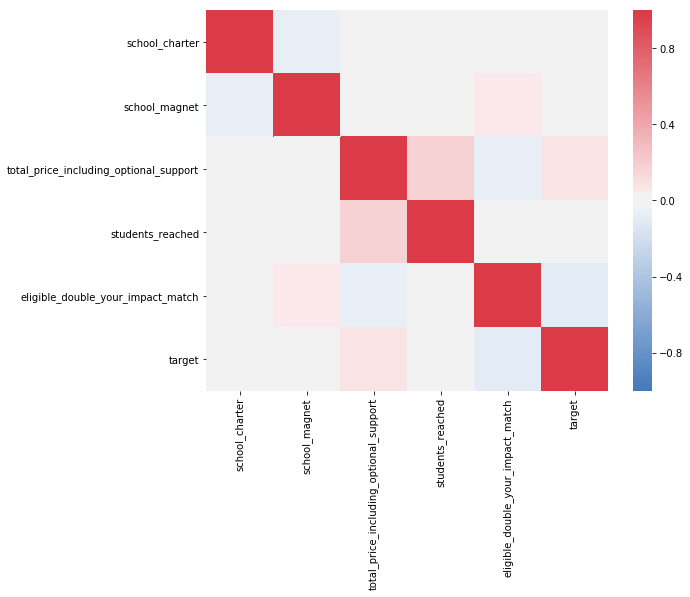

In [2]:
#We note that total price is positively correlated with our target variable
#and "eligible for double your impact match" is negatively correlated
up.create_heatmap(data, (9,7))

In [3]:
#Most of our missing data is in school_metro
up.get_nulls(data)

school_metro                              15224
school_charter                                0
school_magnet                                 0
teacher_prefix                                0
primary_focus_subject                        15
primary_focus_area                           15
resource_type                                17
poverty_level                                 0
grade_level                                   3
total_price_including_optional_support        0
students_reached                             59
eligible_double_your_impact_match             0
date_posted                                   0
datefullyfunded                               0
target                                        0
dtype: int64

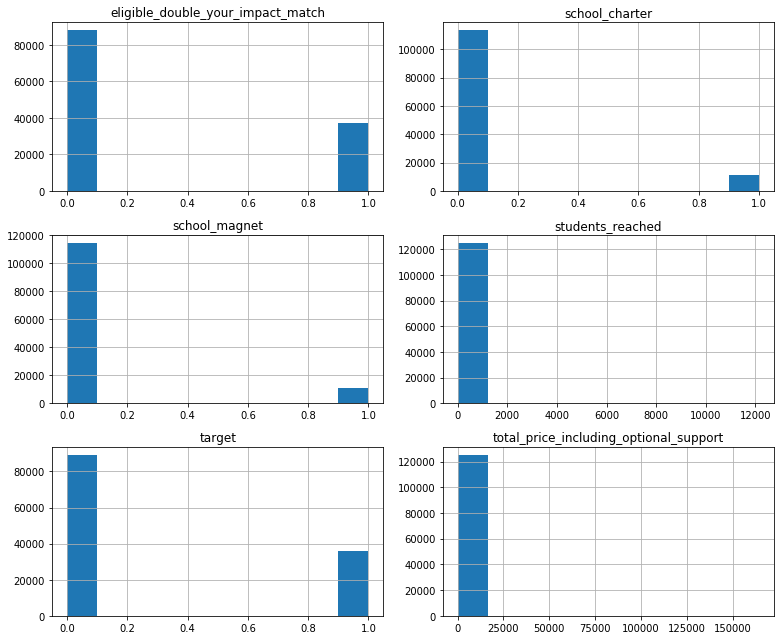

In [4]:
'''
We see that most schools are not charters or magnets. There also appear to
be some extreme outliers among students reached and total price
'''
up.get_histograms(data, (11,9))

In [5]:
'''
By checking the data summaries we confirm that there are extreme outliers
in the total price (with a max over $100,000) and students reached (with
a max over 10,000 students)
'''
up.get_summaries(data, list(data._get_numeric_data().columns))

,school_charter,school_magnet,total_price_including_optional_support,students_reached,eligible_double_your_impact_match,target
count,124976.000000,124976.000000,124976.000000,124917.000000,124976.000000,124976.000000
mean,0.093106,0.085640,654.011811,95.445760,0.296769,0.288135
std,0.290582,0.279833,1098.015854,163.481912,0.456836,0.452896
min,0.000000,0.000000,92.000000,1.000000,0.000000,0.000000
25%,0.000000,0.000000,345.810000,23.000000,0.000000,0.000000
50%,0.000000,0.000000,510.500000,30.000000,0.000000,0.000000
75%,0.000000,0.000000,752.960000,100.000000,1.000000,1.000000
max,1.000000,1.000000,164382.840000,12143.000000,1.000000,1.000000


## Part 2: Splitting and Imputing Data:

We must split our data before imputing in order to preserve the independence of training and testing sets. We choose a rolling window of six months for our test set, giving a total of three training/testing pairs.

Note that we leave a gap of 60 days between training/testing pairs in order to observe outcomes of training data.

In [6]:
'''
Calculates training test splits of:
    TRAINING: 2012/1/1 - 2012/4/30
    TESTING:  2012/7/1 - 2012/10/31
    
    TRAINING: 2012/1/1 - 2012/10/31
    TESTING:  2013/1/1 - 2013/4/30
    
    TRAINING: 2012/1/1 - 2013/4/30
    TESTING:  2013/7/1 - 2013/10/31
'''
splits = up.split_time(data, '2012-01-01', '2013-12-31', [6], 60)

train_test_splits = []
for split in splits:
    
    #Creates train/test pairs
    training, testing = up.create_data_splits(data, split, 'date_posted') 
    
    train_test_splits.append(training)
    train_test_splits.append(testing)

data_splits = []
for data_split in train_test_splits:  

    #Impute values for training, testing sets
    df = up.impute_values(data_split)
        
    #Convert categorical variables to dummies
    df = up.category_to_dummy(df)
    
    data_splits.append(df)
    
#Create list of features
feats = [col for col in data_splits[0].columns if col not in ['date_posted', 'datefullyfunded', 'target']]

#Creates tuples of training/testing pairs
train_test = iter(data_splits)
train_test_pairs = list(zip(train_test, train_test))

## Part 3: Model Building

Here, we establish the parameters and classifiers we will test,
then run the models

In [7]:
#Chosen parameters to run in classification model
parameters = { 
    'RF':{'n_estimators': [10,100,1000,10000], 'max_depth': [1,5,10,20,50,100], 'max_features': ['sqrt','log2'],'min_samples_split': [2,5,10], 'n_jobs': [-1]},
    'LR': { 'penalty': ['l1','l2'], 'C': [0.00001,0.0001,0.001,0.01,0.1,1,10]},
    'AB': { 'algorithm': ['SAMME', 'SAMME.R'], 'n_estimators': [1,10,100,1000,10000]},
    'GB': {'n_estimators': [1,10,100,1000,10000], 'learning_rate' : [0.001,0.01,0.05,0.1,0.5],'subsample' : [0.1,0.5,1.0], 'max_depth': [1,3,5,10,20,50,100]},
    'DT': {'criterion': ['gini', 'entropy'], 'max_depth': [1,5,10,20,50,100],'min_samples_split': [2,5,10]},
    'SVM' :{'C' :[0.00001,0.0001,0.001,0.01,0.1,1,10],'kernel':['linear']},
    'KNN' :{'n_neighbors': [1,5,10,25,50,100],'weights': ['uniform','distance'],'algorithm': ['auto','ball_tree','kd_tree']},
    'BG': {'n_estimators': [1,10,100], 'max_samples': [2, 4, 8, 16, 32]}}

#Chosen thresholds
thresholds = [1.0, 2.0, 5.0, 10.0, 20.0, 30.0, 50.0]

#Models we have chosen to run for DonorsChoose
models_to_run = ['RF', 'LR', 'AB', 'GB', 'DT', 'KNN', 'BG']

#Initialization of chosen classifiers
classifiers = {'RF': up.RandomForestClassifier(n_estimators=50, n_jobs=-1),
               'AB': up.AdaBoostClassifier(up.DecisionTreeClassifier(max_depth=1),
                     algorithm="SAMME", n_estimators=200),
               'LR': up.LogisticRegression(penalty='l1', C=1e5),
               'SVM': up.svm.SVC(kernel='linear', probability=True, random_state=0),
               'GB': up.GradientBoostingClassifier(learning_rate=0.05, subsample=0.5,
                     max_depth=6, n_estimators=10),
               'DT': up.DecisionTreeClassifier(),
               'KNN': up.KNeighborsClassifier(n_neighbors=3),
               'BG': up.BaggingClassifier()}

In [ ]:
results = up.classify(train_test_pairs, classifiers, feats, 'target', parameters, models_to_run, thresholds)

In [21]:
#Evaluation metrics sorted by time period, threshold, and model type
results.groupby(['time_period', 'threshold','model_type']).mean()

auc-roc  accuracy  f1_score  precision  \
time_period threshold model_type                                            
0           0.01      AB          0.500000  0.282047  0.439995   0.282047   
                      BG          0.513047  0.400575  0.382971   0.274000   
                      DT          0.506937  0.296883  0.442447   0.285040   
                      GB          0.500000  0.282047  0.439995   0.282047   
                      KNN         0.536362  0.395365  0.444588   0.301394   
                      LR          0.500082  0.282165  0.440035   0.282080   
                      RF          0.501574  0.287231  0.440124   0.282717   
            0.02      AB          0.500000  0.282047  0.439995   0.282047   
                      BG          0.513047  0.400575  0.382971   0.274000   
                      DT          0.506937  0.296883  0.442447   0.285040   
                      GB          0.500000  0.282047  0.439995   0.282047   
                      KNN         0.536362  0.395365  0.444588   0.301394   
                      LR          0.500444  0.282716  0.440207   0.282227   
                      RF          0.502191  0.288219  0.440421   0.282988   
            0.05      AB          0.500000  0.282047  0.439995   0.282047   
                      BG          0.513047  0.400575  0.382971   0.274000   
                      DT          0.517784  0.315928  0.447421   0.289994   
                      GB          0.500000  0.282047  0.439995   0.282047   
                      KNN         0.536362  0.395365  0.444588   0.301394   
                      LR          0.500889  0.283538  0.440386   0.282408   
                      RF          0.504042  0.291509  0.441221   0.283784   
            0.10      AB          0.500000  0.282047  0.439995   0.282047   
                      BG          0.515317  0.411435  0.382393   0.275120   
                      DT          0.524118  0.331355  0.449572   0.293293   
                      GB          0.500000  0.282047  0.439995   0.282047   
                      KNN         0.546239  0.422041  0.447367   0.306795   
                      LR          0.501001  0.283798  0.440420   0.282454   
                      RF          0.509617  0.302442  0.443485   0.286323   
            0.20      AB          0.500000  0.282047  0.439995   0.282047   
                      BG          0.522078  0.440091  0.380792   0.278611   
                      DT          0.592375  0.479974  0.479996   0.335079   
                      GB          0.500000  0.282047  0.439995   0.282047   
                      KNN         0.558609  0.503239  0.437046   0.322102   
                      LR          0.533765  0.347064  0.453933   0.297062   
                      RF          0.544831  0.373015  0.459076   0.305060   
            0.30      AB          0.500000  0.282047  0.439995   0.282047   
                      BG          0.542142  0.537990  0.360781   0.292908   
                      DT          0.609607  0.547943  0.483529   0.357183   
                      GB          0.605891  0.506943  0.487943   0.345166   
                      KNN         0.557969  0.531964  0.425848   0.328653   
                      LR          0.596636  0.555580  0.467237   0.353010   
                      RF          0.600617  0.545644  0.472508   0.351208   
            0.50      AB          0.500000  0.717953  0.000000   0.000000   
                      BG          0.518573  0.666307  0.174110   0.275370   
                      DT          0.527269  0.698293  0.173427   0.271658   
                      GB          0.500000  0.717953  0.000000   0.000000   
                      KNN         0.535727  0.657524  0.290624   0.357358   
                      LR          0.518288  0.712459  0.124079   0.439680   
                      RF          0.510218  0.711606  0.070599   0.308806   
1           0.01      AB          0.500000  0.294592  0.455111   0.294592   
                      BG       